In [11]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [12]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [13]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc

In [14]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [15]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [16]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [17]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [18]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [141]:
# Find the most recent date in the data set.
most_recent_measurement = session.query(Measurement).order_by(desc(Measurement.date)).first().date
print(most_recent_measurement)

2017-08-23


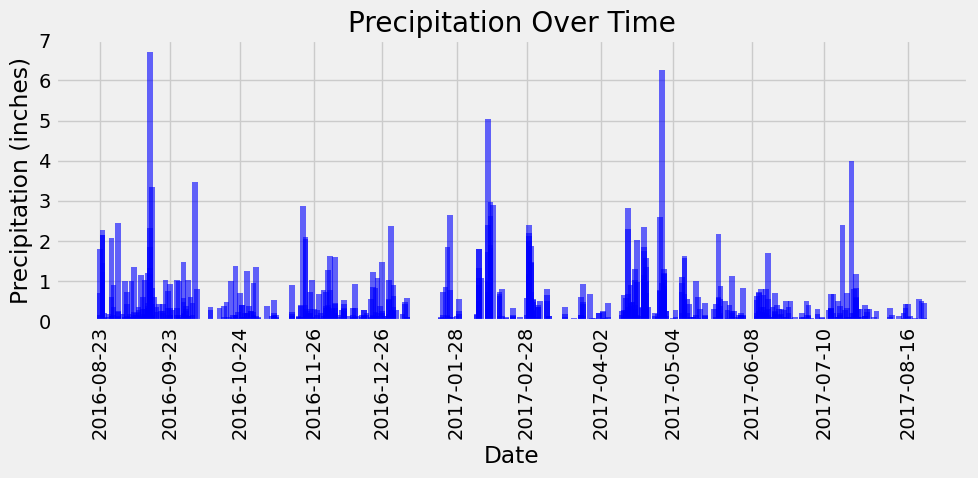

In [144]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = dt.datetime.strptime(most_recent_measurement, '%Y-%m-%d').date()

# Calculate the date one year prior to the most recent date
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_12_months_precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(last_12_months_precipitation, columns=['date', 'precipitation'])
precipitation_df.sort_values(by='date', inplace=True)
precipitation_df.reset_index(drop=True, inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 5))
bar_width = 2.5
plt.bar(measurement_df['date'], measurement_df['precipitation'], color='blue', alpha=0.6, width=bar_width)


plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Over Time')
plt.ylim(0,7)

tick_indices = range(0, len(measurement_df), 200)  
plt.xticks(ticks=measurement_df['date'].iloc[tick_indices], 
           labels=measurement_df['date'].iloc[tick_indices], 
           rotation=90)

plt.tight_layout()
plt.show()

In [145]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [24]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station.station).distinct().all()
print(station_count)

[('USC00519397',), ('USC00513117',), ('USC00514830',), ('USC00517948',), ('USC00518838',), ('USC00519523',), ('USC00519281',), ('USC00511918',), ('USC00516128',)]


In [82]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(
    Measurement.station,
    func.count(Measurement.station).label('count')
).group_by(Measurement.station)
active_stations = active_stations.order_by(desc('count')).all()  # Order by count in descending order

# Print the results
for station, count in active_stations:
    print(station, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [88]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station_temperatures = session.query(
    func.min(Measurement.tobs).label('min_temp'),   
    func.max(Measurement.tobs).label('max_temp'),   
    func.avg(Measurement.tobs).label('avg_temp')    
).filter(Measurement.station == 'USC00519281').all()

print(active_station_temperatures)

[(54.0, 85.0, 71.66378066378067)]


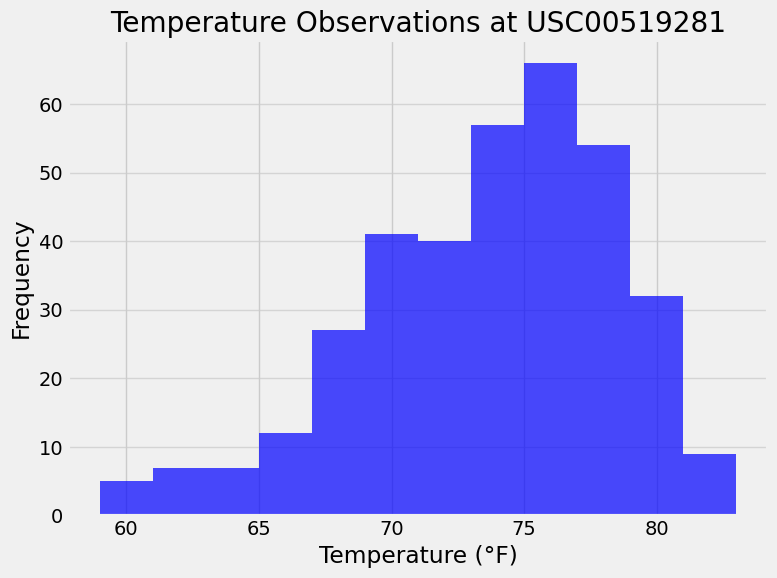

In [118]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_recent_station_date = session.query(Measurement).filter(Measurement.station == 'USC00519281')\
    .order_by(desc(Measurement.date)).first().date

recent_station_date = dt.datetime.strptime(most_recent_station_date, '%Y-%m-%d').date()
# Calculate the date one year prior to the most recent observation
one_year_ago_station_date = recent_station_date - timedelta(days=365)

# Query the last 12 months of temperature observation data for this station
active_station_data = session.query(Measurement).filter(
    Measurement.station == 'USC00519281',
    Measurement.date >= one_year_ago_station_date
).all()

# Prepare the data for the DataFrame
active_station_columns = {
    "station": [measurement.station for measurement in active_station_data],
    "date": [measurement.date for measurement in active_station_data],
    "precipitation": [measurement.prcp for measurement in active_station_data],
    "temperature": [measurement.tobs for measurement in active_station_data]
}
active_station_df = pd.DataFrame(active_station_columns)

# Create the histogram
plt.figure(figsize=(8, 6))
plt.hist(active_station_df['temperature'], color='blue', bins=12, alpha=0.7)
plt.title('Temperature Observations at USC00519281')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)


plt.tight_layout()
plt.show()

# Close Session

In [119]:
# Close Session
session.close()